In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))


In [2]:
# get the data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
print(train.shape, test.shape)

(42000, 785) (28000, 784)


In [3]:
# divide train into X_train and y_train
X_train = train.drop("label",axis=1)
X_test = test
y_train = np.array(train['label'])
X_train.shape, y_train.shape


((42000, 784), (42000,))

In [4]:
# reshape
X_train = X_train.values.reshape(-1,28,28)
X_test = X_test.values.reshape(-1,28,28)
print(X_train.shape, X_test.shape)

(42000, 28, 28) (28000, 28, 28)


In [5]:
# divide into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=2)

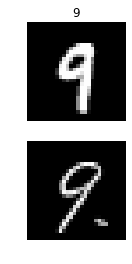

In [6]:
# look at random samples
i = 2
#print(y_train[i])
plt.subplot(2,1,1)
plt.imshow(X_train[i,:,:], cmap='gray')
plt.title(y_train[i])
plt.axis('off')

plt.subplot(2,1,2)
plt.imshow(X_test[i,:,:], cmap='gray')
plt.axis('off')

plt.show()

# double image: 1 from train and 1 from test

In [7]:
# probably should normalize or smth, not sure though

In [8]:
# convert numpy arrays to torch tensors
X_train = torch.from_numpy(X_train).float().unsqueeze(1)
X_train.requires_grad = True
#X_train = X_train.view(X_train.size()[0], -1)

X_test = torch.from_numpy(X_test).float().unsqueeze(1)
#X_test = X_test.view(X_test.size()[0], -1)

X_val = torch.from_numpy(X_val).float().unsqueeze(1)
#X_val = X_val.view(X_val.size()[0], -1)

y_train = torch.from_numpy(y_train).long()
y_val = torch.from_numpy(y_val).long()

In [9]:
# make a model
import torch.nn.functional as F

class CNet(torch.nn.Module):
    def __init__(self, output_channels_1, output_channels_2, n_hidden_neurons_1, n_hidden_neurons_2):
        super(CNet, self).__init__()
        self.c1 = torch.nn.Conv2d(1,output_channels_1,5)
        self.c2 = torch.nn.Conv2d(output_channels_1,output_channels_2,3)
        self.l1 = torch.nn.Linear(output_channels_2*5*5, n_hidden_neurons_1)
        self.l2 = torch.nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.l3 = torch.nn.Linear(n_hidden_neurons_2, 10)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.c1(x)), 2)
        x = F.max_pool2d(F.relu(self.c2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

mnist_net = CNet(8,32,256,128)

In [10]:
# move to device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)

# initiate optimizer
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [11]:
# train a model + append error

batch_size = 2100

train_accuracy_history = []
val_accuracy_history = []

for epoch in range(1,21):
    order = np.random.permutation(len(X_train))
    
    for _, start_index in enumerate(tqdm(range(0, len(X_train), batch_size))):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    train_preds = torch.tensor([])
    for start_index in range(0, len(X_train), batch_size):
        batch_indexes = range(start_index,start_index+batch_size)
        X_train_batch = X_train[batch_indexes].to(device)
        train_preds = torch.cat((train_preds, mnist_net.forward(X_train_batch).cpu()),0)
        
    val_preds = torch.tensor([])
    for start_index in range(0, len(X_val), batch_size):
        batch_indexes = range(start_index,start_index+batch_size)
        X_val_batch =  X_val[batch_indexes].to(device)
        val_preds = torch.cat((val_preds, mnist_net.forward(X_val_batch).cpu()),0)
    
    #test_loss_history.append(loss(test_preds, y_test))
    
    train_accuracy = (train_preds.argmax(dim=1) == y_train).float().mean()
    val_accuracy = (val_preds.argmax(dim=1) == y_val).float().mean()
    
    train_accuracy_history.append(train_accuracy)
    val_accuracy_history.append(val_accuracy)
    
    print('Epoch',epoch)
    print('Accuracy: train', round(train_accuracy.item(),5), 'validation', round(val_accuracy.item(),5))


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1
Accuracy: train 0.77087 validation 0.77095


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2
Accuracy: train 0.92164 validation 0.91976


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3
Accuracy: train 0.9514 validation 0.94738


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4
Accuracy: train 0.96728 validation 0.95929


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5
Accuracy: train 0.97455 validation 0.96548


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6
Accuracy: train 0.97783 validation 0.97476


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7
Accuracy: train 0.98344 validation 0.97857


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8
Accuracy: train 0.98598 validation 0.97833


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9
Accuracy: train 0.98823 validation 0.97881


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10
Accuracy: train 0.99013 validation 0.98286


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11
Accuracy: train 0.99161 validation 0.98238


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12
Accuracy: train 0.99228 validation 0.98119


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13
Accuracy: train 0.99357 validation 0.98405


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14
Accuracy: train 0.99421 validation 0.9831


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15
Accuracy: train 0.99474 validation 0.98262


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16
Accuracy: train 0.99503 validation 0.98548


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17
Accuracy: train 0.99643 validation 0.98333


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18
Accuracy: train 0.99704 validation 0.985


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19
Accuracy: train 0.99759 validation 0.98381


100%|██████████| 18/18 [00:09<00:00,  1.94it/s]


Epoch 20
Accuracy: train 0.99772 validation 0.98595


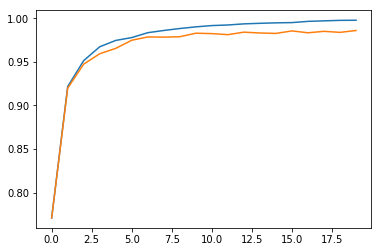

In [12]:
# show graph of train and validation error over epoch
plt.plot(train_accuracy_history)
plt.plot(val_accuracy_history)

In [13]:
test_pred = mnist_net.forward(X_test).argmax(dim=1)
test_pred = pd.Series(test_pred, name='Label')
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),test_pred],axis = 1)
submission.to_csv("mnist_fcnn.csv",index=False)

In [14]:
# use gpu
# find a model that does atleast 99.5